# TODO:
 - best stack rule in
 - stack contains surface for empirical depth estimate
 - model performance in our hands
 - retinotopy candidate rule in
 - dotmapping candidate rule in

In [1]:
import numpy as np
import static_nda as nda
from pipeline import stack, meso, treadmill
from stimulus import stimulus
import pandas as pd
import datajoint as dj
import matplotlib.pyplot as plt
maps = dj.create_virtual_module('pipeline_map','pipeline_map')
anat = dj.create_virtual_module('pipeline_anatomy','pipeline_anatomy')
pupil = dj.create_virtual_module('pipeline_eye','pipeline_eye')
# dics = np.load('/mnt/scratch07/zhiwei/static_scan_release_keys.npy', allow_pickle=True)
dics = np.load('/mnt/scratch07/zhiwei/static_scan_release_keys_filtered.npy', allow_pickle=True)

Loading local settings from pipeline_config.json
Connecting pfahey@at-database.ad.bcm.edu:3306


In [2]:
dics

array([{'animal_id': 21067, 'session': 9, 'scan_idx': 17, 'pipe_version': 1, 'group_id': 29, 'segmentation_method': 6, 'spike_method': 5, 'preproc_id': 0, 'stack': '21067-9-1', 'album_id': 2},
       {'animal_id': 21067, 'session': 10, 'scan_idx': 18, 'pipe_version': 1, 'group_id': 35, 'segmentation_method': 6, 'spike_method': 5, 'preproc_id': 0, 'stack': '21067-10-25', 'album_id': 2},
       {'animal_id': 21067, 'session': 13, 'scan_idx': 14, 'pipe_version': 1, 'group_id': 38, 'segmentation_method': 6, 'spike_method': 5, 'preproc_id': 0, 'stack': '21067-13-2', 'album_id': 2},
       {'animal_id': 22620, 'session': 4, 'scan_idx': 15, 'pipe_version': 1, 'group_id': 55, 'segmentation_method': 6, 'spike_method': 5, 'preproc_id': 0, 'stack': '22620-4-16', 'album_id': 2},
       {'animal_id': 22620, 'session': 4, 'scan_idx': 17, 'pipe_version': 1, 'group_id': 69, 'segmentation_method': 6, 'spike_method': 5, 'preproc_id': 0, 'stack': '22620-4-16', 'album_id': 2},
       {'animal_id': 22620, 

In [7]:
pd.DataFrame(nda.Scan())

,animal_id,session,scan_idx,nframes,nfields,fps
0,21067,9,17,48252,10,7.97908
1,21067,10,18,49431,10,7.97908
2,21067,13,14,52671,10,7.97908
3,22620,4,15,49122,10,7.97908
4,22620,4,17,51593,10,7.97908
5,22620,5,11,48647,10,7.97908
6,22846,2,19,48050,10,7.97908
7,22846,2,21,55188,10,7.97908
8,22846,7,15,48123,10,7.97908
9,22846,10,16,48475,10,7.97908


# Stimulus Composition

All stimulus conditions in the 14 scans are of the `stimulus.Frame` type.  30600 total unique stimulus conditions are shown.  The plot below can be used to identify scans that use each of the 6 different stimulus blocks.  However, 5000 condition hashes are the same image used twice with different pre-blank durations, corresponding to the second and third blocks from the left (haven't reconfirmed this).  100 condition hashes are the same image used seven times with different pre-blank durations, likely corresponding to the oracle clips.  The remaining 25000 conditions are unique.  Thus, there are actually 6 different stimulus sets represented in the 14 selected scans. 

stimulus_type class name of the special stimulus condition table class
stimulus.Frame


total stimulus conditions shown:  30600


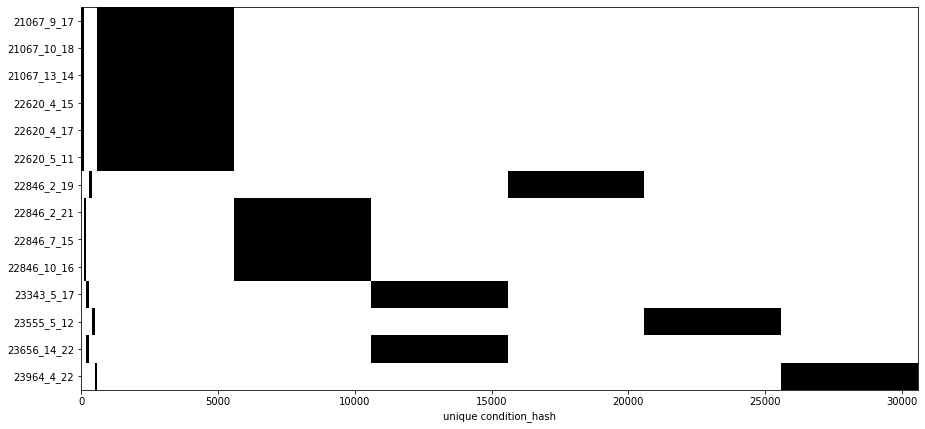

image_class,image_id image id,n calculated attribute
imagenet,0,1
imagenet,2,1
imagenet,4,1
imagenet,5,1
imagenet,7,1
imagenet,10,1
imagenet,13,1
imagenet,15,1
imagenet,16,1
imagenet,17,1


image_class,image_id image id,n calculated attribute
imagenet,16717,2
imagenet,16718,2
imagenet,16719,2
imagenet,16720,2
imagenet,16721,2
imagenet,16722,2
imagenet,16723,2
imagenet,16724,2
imagenet,16725,2
imagenet,16726,2


image_class,image_id image id,n calculated attribute
imagenet,104,6
imagenet,128,6
imagenet,183,6
imagenet,355,6
imagenet,479,6
imagenet,483,6
imagenet,656,6
imagenet,803,6
imagenet,830,6
imagenet,936,6


scans containing condition_hashes with non_unique images: 


animal_id Animal ID,session Session ID,scan_idx Scan ID
23964,4,22
22846,2,21
22846,7,15
22846,10,16


In [14]:
display(dj.U('stimulus_type') & ((stimulus.Trial & nda.Scan) * stimulus.Condition()))

all_hashes = dj.U('condition_hash','n_total','min_animal','min_scan','min_session') & dj.U('condition_hash').aggr(stimulus.Trial & nda.Scan,
                                                                            n_total='count(*)',
                                                                            min_animal='MIN(animal_id)',
                                                                            min_scan = 'MIN(scan_idx)', 
                                                                            min_session = 'MIN(session)')
print('total stimulus conditions shown: ', len(all_hashes))
hash_presence = []
for scan in nda.Scan():
    scan_hashes = (all_hashes.aggr(stimulus.Trial & scan,n_scan = 'count(trial_idx)',
                                   keep_all_rows=True)).fetch('n_scan',
                                   order_by='n_total DESC, min_animal ASC, min_scan ASC, min_session ASC')
    hash_presence.append({'scan_key':scan,'hash_presence':scan_hashes})
    
fig,ax = plt.subplots(figsize=(15,15))
ax.imshow(np.vstack([s['hash_presence'] for s in hash_presence])>0,cmap='binary',interpolation='none')
ax.set_aspect(1000)
ax.set_xlabel('unique condition_hash')
ax.set_yticks(np.arange(len(nda.Scan())))
_ = ax.set_yticklabels(['_'.join([str(s) for s in key.values()]) for key in nda.Scan.proj()])
plt.show()
plt.close()

repeat_rel = dj.U('image_class','image_id').aggr(stimulus.Frame & (stimulus.Trial & nda.Scan),n='count(*)')
no_repeat = repeat_rel & 'n=1'
display(no_repeat)
two_repeat = repeat_rel & 'n=2'
display(two_repeat)
seven_repeat = repeat_rel & 'n=6'
display(seven_repeat)

print('scans containing condition_hashes with non_unique images: ')
display(nda.Scan.proj() & (stimulus.Trial & (stimulus.Frame & two_repeat.proj())))

# Animal / Session distribution

In [8]:
print('number of scans: ', len(nda.Scan()))
print('number of unique sessions: ', len(dj.U('animal_id','session') & nda.Scan))
print('number of unique animals: ', len(dj.U('animal_id') & nda.Scan))
display(nda.Scan.proj())

number of scans:  14
number of unique sessions:  12
number of unique animals:  7


animal_id Animal ID,session Session ID,scan_idx Scan ID
21067,9,17
21067,10,18
21067,13,14
22620,4,15
22620,4,17
22620,5,11
22846,2,19
22846,2,21
22846,7,15
22846,10,16


# Same Animal, Same Session, Same XYZ motor coordinates

Of the 14 scans, 4 are from sessions where two scans were collected within the same session.  The motor coordinates of these scans suggest that they are covering overlapping volumes (ie not at a different xy position or at a radically different z position). If we choose to simplify the dataset, we would want to choose one out of each of these pairs and remove the other from the dataset.  If we wanted to maintain the ability to compare repeat scans of the same neurons at the cost of complicating general dataset use, we could retain these pairs and somehow indicate that they contain repeat information on the same body of neurons (even greater than existing intrascan redundancy between planes).  

In [15]:
u_loc_rel = dj.U('animal_id','session','scan_idx','x','y')
shared_sess_rel = (nda.Scan.proj() & (dj.U('animal_id','session').aggr(nda.Scan,n='count(*)') & 'n>1').proj())
display(u_loc_rel.aggr(meso.ScanInfo.Field & shared_sess_rel,mean_z = 'AVG(z)'))

animal_id id number,session session index for the mouse,scan_idx number of TIFF stack file,x (um) center of field in the motor coordinate system,y (um) center of field in the motor coordinate system,mean_z calculated attribute
22620,4,15,-395.0,420.0,222.5
22620,4,17,-395.0,420.0,219.5
22846,2,19,-940.0,-50.0,232.5
22846,2,21,-940.0,-50.0,229.5


# Same Animal, Different Session, Same XYZ registered coordinates

Of the 14 scans, 10 are from animals where more than one scan was collected from that animal.  Reducing these to 1 scan per animal would remove 7 scans from the set, leaving 7 scans unique to each animal.  This would also resolve the `same animal, same session, same coordinates` conflict for the 4 scans mentioned above.  In some cases, registration into the same stack shows that the xyz coordinates of the scans represent overlapping volumes:
- 21067: 3/3 scans overlap in at least one stack
- 22620: 3/3 scans overlap in at least one stack, including 2 from the same session
- 22846: 2/4 scans overlap in at least one stack (also from same session), remaining 2 are not yet coregistered

Thus, while it is not guaranteed that repeat scans in the same animal would repeat in the same animal, 8 of these scans are demonstrated to overlap with at least one other scan by coregistration, with 2 unknown scans (22846) not yet coregistered with any other scan. 

In [18]:
shared_animal_rel = (dj.U('animal_id').aggr(nda.Scan,n='count(*)') & 'n>1')
display(shared_animal_rel)

group_strs = ['animal_id','stack_session','stack_idx','scan_session','scan_idx','registration_method']
shared_animal_scans = (nda.Scan & shared_animal_rel.proj()).proj(scan_session='session')
shared_animal_reg = dj.U(*group_strs,'reg_x','reg_y','reg_z','score') & \
                        (stack.Registration.Affine & shared_animal_scans)
pd.DataFrame(shared_animal_reg).groupby(by=group_strs).mean()

animal_id Animal ID,n calculated attribute
21067,3
22620,3
22846,4


reg_x  \
animal_id stack_session stack_idx scan_session scan_idx registration_method              
21067     9             1         9            17       5                    -373.6887   
                                  10           18       5                    -385.4123   
                                  13           14       5                    -387.8488   
          10            25        9            17       5                    -489.4673   
                                  10           18       5                    -501.2446   
                                  13           14       5                    -503.3757   
          11            3         9            17       5                    -463.2160   
                                  10           18       5                    -474.8957   
                                  13           14       5                    -477.2515   
          12            1         9            17       5                    -425.1948   
                                  10           18       5                    -436.9037   
                                  13           14       5                    -439.1260   
          13            2         9            17       5                    -443.9034   
                                  10           18       5                    -455.5362   
                                  13           14       5                    -457.8177   
22620     4             16        4            15       5                    -397.4580   
                                               17       5                    -396.0446   
                                  5            11       5                    -391.0473   
          5             14        4            15       5                    -564.9805   
                                               17       5                    -563.5701   
                                  5            11       5                    -558.5546   
          6             10        4            15       5                    -532.6005   
                                               17       5                    -531.2208   
                                  5            11       5                    -526.1343   
          7             14        4            15       5                    -734.3893   
                                               17       5                    -732.9977   
                                  5            11       5                    -727.9239   
22846     2             20        2            19       5                    -938.2024   
                                               21       5                    -942.6709   
          3             15        2            19       5                    -867.4526   
                                               21       5                    -872.0649   
          7             14        7            15       5                   -1047.8580   
          8             7         7            15       5                   -1042.1090   
          10            17        10           16       5                    -845.8688   
                        20        10           16       5                    -834.5919   
          11            9         10           16       5                    -814.8509   
          12            14        10           16       5                    -818.7348   

                                                                                 reg_y  \
animal_id stack_session stack_idx scan_session scan_idx registration_method              
21067     9             1         9            17       5                    220.33610   
                                  10           18       5                    221.98580   
                                  13           14       5                    213.83710   
          10            25        9            17       5                    223.23420   
                              

# Scan Not Registered in Any Stack

Of the 14 scans, all 14 are registered in at least one stack.  

In [23]:
nda.Scan.proj(scan_session = 'session') & stack.Registration

animal_id Animal ID,scan_session Session ID,scan_idx Scan ID
21067,9,17
21067,10,18
21067,13,14
22620,4,15
22620,4,17
22620,5,11
22846,2,19
22846,2,21
22846,7,15
22846,10,16


# Stack Inclusion

If we want to include any stack related data (drift over time, for example), we will need to identify which stack are appropriate for registration and choose the best one.  Additionally, some stacks also offer additional parameters (estimate of scan ROI from surface depth) only if they are sufficiently large / tall, which is not guaranteed. 

# Retinotopy for Scan ROI position relative to retinotopy / area boundaries

All scans have at least one retinotopic type scan logged in maps.OptImageBar, Manolis old pipeline for converting our retinotopic mapping stimulus to sign maps for area mapping. Before these can be prepared for the release, we will have to confirm the quality of the retinotopic scan, the quality of the manual masking, and whether an adequate retinotopic scan w/w/o masking includes the scanned area (since these animals were reused for multiple purposes, it may be a ROI retinotopy partially / completely excluding the area of current interest).  Additionally, these scans are not and cannot be automatically registered into the stacks above, so relative position would need to be done via manual registration, for which there is no current common workflow. 

In [19]:
print('has at least one retinotopic scan: ', 
      len((dj.U('animal_id') & nda.Scan) & (maps.OptImageBar & (dj.U('animal_id') & nda.Scan))), '/ 7')
print('has at least one retinotopic scan with manual mask annotation: ', 
      len((dj.U('animal_id') & nda.Scan) & anat.AreaMask & (dj.U('animal_id') & nda.Scan)), '/ 7')

has at least one retinotopic scan:  7 / 7
has at least one retinotopic scan with manual mask annotation:  6 / 7


In [9]:
anat.AreaMask & 'animal_id = 22620'

animal_id id number,session session index for the mouse,scan_idx number of TIFF stack file,brain_area area name,field,ret_idx retinotopy map index for each animal,mask mask of area


In [8]:
nda.Scan - (dj.U('animal_id') & (anat.AreaMask & (dj.U('animal_id') & nda.Scan())))

animal_id Animal ID,session Session ID,scan_idx Scan ID,nframes number of frames per scan,nfields number of fields per scan,fps frames per second (Hz)
22620,4,15,49122,10,7.97908
22620,4,17,51593,10,7.97908
22620,5,11,48647,10,7.97908


# DotMapping for Monitor Position

All 12 sessions currently included have a scan with at least one dotmapping trial in the same session.  Only dotmapping scans that are confirmed by the experimenter to have the monitor in the same position for both the dotmapping scan and the scan of interest can be used, and there is no way to prove this interaction from the data other than from the experimenter's notes.  In order to include the dotmapping data, we will have to first identify which are these dotmapping scans are of adequate quality and are confirmed to match the monitor position for the scan of interest.  

In [28]:
print('has at least one dotmapping trial: ',
       len(dj.U('animal_id', 'session') & (stimulus.Trial & (dj.U('animal_id','session') & nda.Scan)) & 
           stimulus.SingleDot()), '/ 12')

has at least one dotmapping trial:  12 / 12


# Automatic Eye Tracking

Eye tracking appears to be complete for all 22 scans.  I have not personally inspected the eye tracking for gaps at a closer level (we should confirm this was done as part of the 22 scan selection criteria), as well as any other notable deviations for normal eye tracking profiles. 

In [29]:
print('scan has automatic eye tracking in database: ', len(nda.Scan() & pupil.FittedPupil), '/ 14')

scan has automatic eye tracking in database:  14 / 14


In [30]:
scan_rs = []
for scan in nda.Scan.proj():
    rs,ids = (pupil.FittedPupil.Circle & scan).fetch('radius','frame_id')
    scan_rs.append({'scan_key':scan,'radii':rs,'frame_ids':ids})

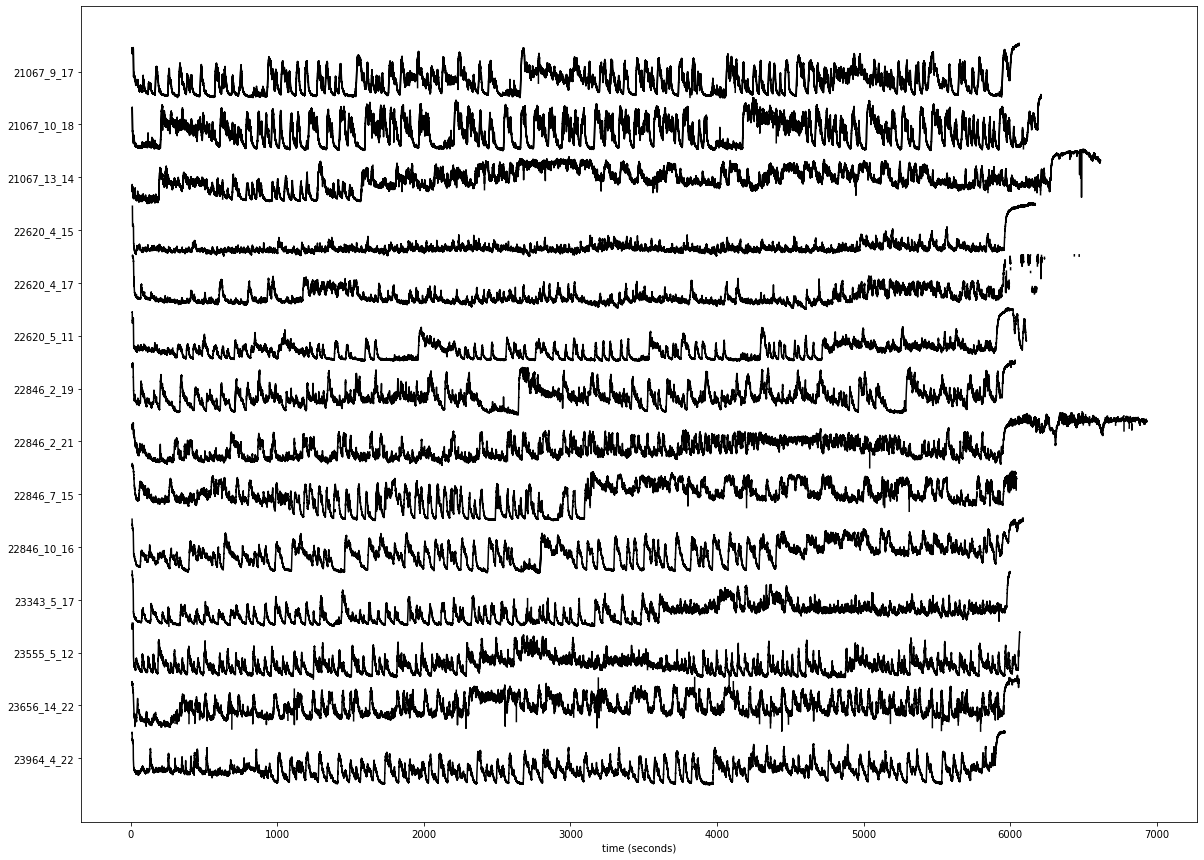

In [31]:
fig,ax = plt.subplots(figsize=(20,15))
for i,scan in enumerate(scan_rs):
    ts = np.array((pupil.Eye & scan['scan_key']).fetch1('eye_time'))
    ts -= np.nanmin(ts)
    ts = ts[scan['frame_ids']]
    rs = scan['radii']
    rs -= np.nanmin(rs)
    rs /= np.nanpercentile(rs,99.9)
    ax.plot(ts,rs-i,'k')
ax.set_yticks(0.5-np.arange(len(scan_rs)))
ax.set_yticklabels(['_'.join([str(s) for s in scan['scan_key'].values()]) for scan in scan_rs])
_ = ax.set_xlabel('time (seconds)')

# Treadmill

Treadmill traces appear to be complete for all 14 scans.  Unclear if there are any warning flags in treadmill traces that would warrant removal. 

scan has treadmill in database:  14 / 14


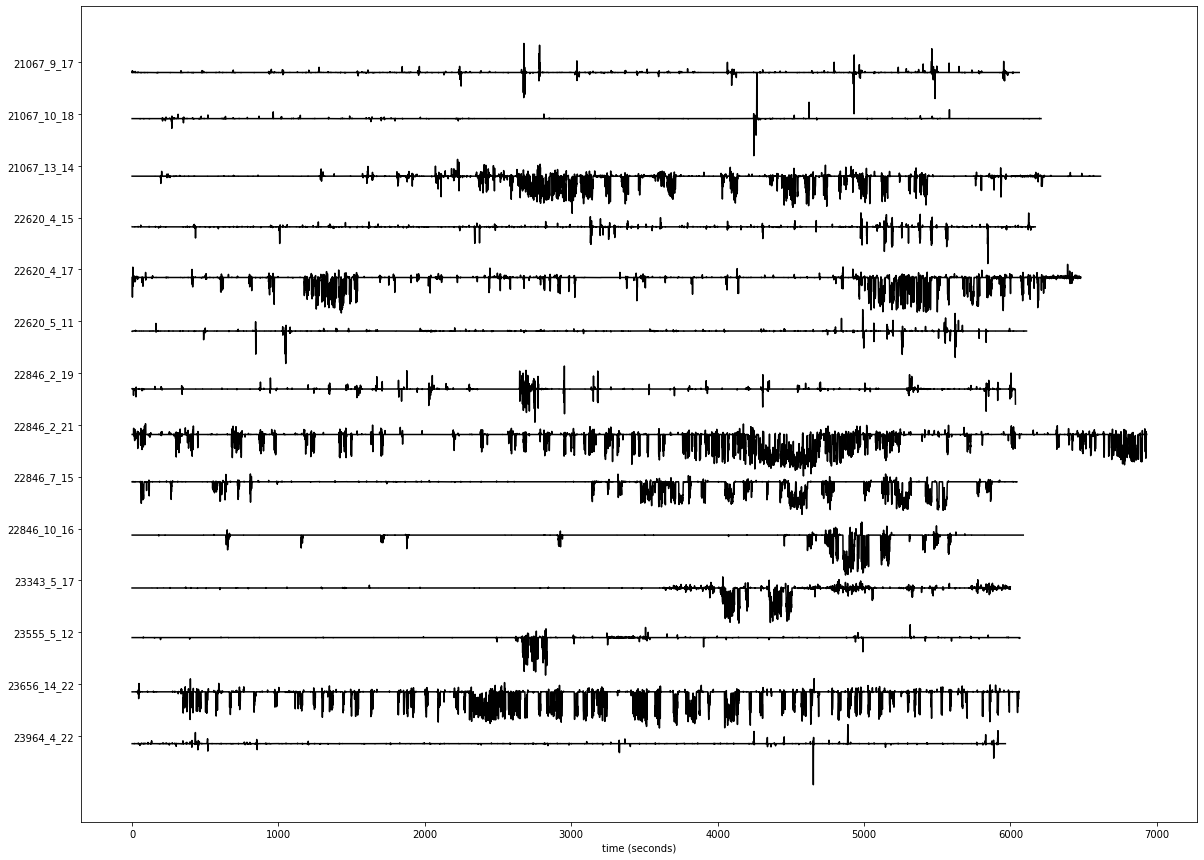

In [32]:
print('scan has treadmill in database: ', len(nda.Scan() & treadmill.Treadmill), '/ 14')
keys,vels,times = (treadmill.Treadmill & nda.Scan).fetch('KEY','treadmill_vel','treadmill_time')
fig,ax = plt.subplots(figsize=(20,15))
for i,(k,v,t) in enumerate(zip(keys,vels,times)):
    t = np.array(t)
    t -= np.nanmin(t)
    v = np.array(v)
    v -= np.nanmin(v)
    v /= np.nanpercentile(v,99.9)
    ax.plot(t[::100],v[::100]-i,'k')
ax.set_yticks(1 - np.arange(len(keys)))
ax.set_yticklabels(['_'.join([str(s) for s in k.values()]) for k in keys])
_ = ax.set_xlabel('time (seconds)')
                      


# Case by Case

### 21067
Three scans that share the same stimulus condition_hash set and same xyz location in coregistered stacks.  One of the three should be chosen. 

In [34]:
display(nda.Scan & {'animal_id':21067})

animal_id Animal ID,session Session ID,scan_idx Scan ID,nframes number of frames per scan,nfields number of fields per scan,fps frames per second (Hz)
21067,9,17,48252,10,7.97908
21067,10,18,49431,10,7.97908
21067,13,14,52671,10,7.97908


### 22620
Three scans that share the same stimulus condition_hash set and same xyz location in a coregistered stacks.  One of the three should be chosen.

In [35]:
display(nda.Scan & {'animal_id':22620})

animal_id Animal ID,session Session ID,scan_idx Scan ID,nframes number of frames per scan,nfields number of fields per scan,fps frames per second (Hz)
22620,4,15,49122,10,7.97908
22620,4,17,51593,10,7.97908
22620,5,11,48647,10,7.97908


### 22846
Of the four scans, two are from the same session (2_19, 2_21) and have the same xyz location in coregistered stacks.  Of these two, one should be chosen.  2_19 is the only one of its stimulus set, it should be preferred over 2_21. 
Of the remaining two, they are never coregistered with the session 2 scans or with each other.  By visual inspection of the average scan image, it would appear that the four imaging sites are partially overlapping.  In that case, the safest approach would be to only choose one scan out of the four (2_19 still preferred).  In fact, if we keep 2_19 and drop the other three, then we won't have to explain that the second and third blocks in the stimulus composition figure at the top of the page differ only in the presentation delay and not in the image shown. 

animal_id Animal ID,session Session ID,scan_idx Scan ID,nframes number of frames per scan,nfields number of fields per scan,fps frames per second (Hz)
22846,2,19,48050,10,7.97908
22846,2,21,55188,10,7.97908
22846,7,15,48123,10,7.97908
22846,10,16,48475,10,7.97908


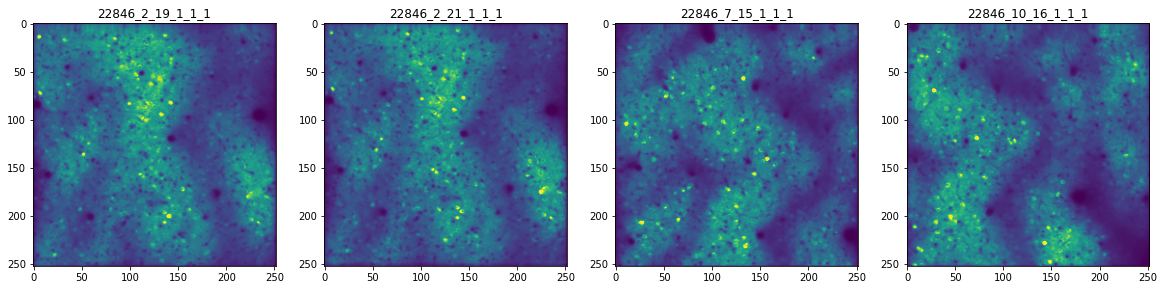

In [36]:
display(nda.Scan & {'animal_id':22846})

keys,av_ims = (meso.SummaryImages.Average & 
               (nda.Scan & {'animal_id':22846}).proj() & 
               {'field':1}).fetch('KEY','average_image')
fig,axes = plt.subplots(1,4,figsize=(20,5))
for k,im,ax in zip(keys,av_ims,axes):
    ax.imshow(im,vmin=np.percentile(im,0.1),vmax=np.percentile(im,99.9))
    ax.set_title('_'.join([str(s) for s in k.values()]))
    
plt.show()
plt.close()

### 23343
Only one scan, retain. 

In [37]:
display(nda.Scan & {'animal_id':23343})

animal_id Animal ID,session Session ID,scan_idx Scan ID,nframes number of frames per scan,nfields number of fields per scan,fps frames per second (Hz)
23343,5,17,47766,10,7.97908


### 23555
Only one scan, retain. 

In [38]:
display(nda.Scan & {'animal_id':23555})

animal_id Animal ID,session Session ID,scan_idx Scan ID,nframes number of frames per scan,nfields number of fields per scan,fps frames per second (Hz)
23555,5,12,48300,10,7.97908


### 23656
Only one scan, retain. 

In [44]:
display(nda.Scan & {'animal_id':23656})

animal_id Animal ID,session Session ID,scan_idx Scan ID,nframes number of frames per scan,nfields number of fields per scan,fps frames per second (Hz)
23656,14,22,48245,10,7.97908


### 23964
Only one scan, retain. 

In [45]:
display(nda.Scan & {'animal_id':23964})

animal_id Animal ID,session Session ID,scan_idx Scan ID,nframes number of frames per scan,nfields number of fields per scan,fps frames per second (Hz)
23964,4,22,47517,10,7.97908
